# Enzyme Detector

In [2]:
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root="./datasets/", name="PROTEINS").shuffle()

print(f"Dataset: {dataset}")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of nodes: {dataset[0].x.shape[0]}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

Extracting datasets/PROTEINS/PROTEINS.zip
Processing...


Dataset: PROTEINS(1113)
Number of graphs: 1113
Number of nodes: 14
Number of features: 3
Number of classes: 2


Done!


In [3]:
from torch_geometric.loader import DataLoader

train_dataset = dataset[: int(len(dataset) * 0.8)]
val_dataset = dataset[int(len(dataset) * 0.8) : int(len(dataset) * 0.9)]
test_dataset = dataset[int(len(dataset) * 0.9) :]

print(f"Training set = {len(train_dataset)} graphs")
print(f"Validation set = {len(val_dataset)} graphs")
print(f"Test set = {len(test_dataset)} graphs")

# Create mini-batches. Each batch will contain up to 64 graphs
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Training set = 890 graphs
Validation set = 111 graphs
Test set = 112 graphs


In [4]:
for i in range(10):
    print(train_dataset[i])

Data(edge_index=[2, 62], x=[14, 3], y=[1])
Data(edge_index=[2, 154], x=[38, 3], y=[1])
Data(edge_index=[2, 382], x=[98, 3], y=[1])
Data(edge_index=[2, 32], x=[9, 3], y=[1])
Data(edge_index=[2, 68], x=[20, 3], y=[1])
Data(edge_index=[2, 90], x=[25, 3], y=[1])
Data(edge_index=[2, 82], x=[22, 3], y=[1])
Data(edge_index=[2, 92], x=[26, 3], y=[1])
Data(edge_index=[2, 102], x=[25, 3], y=[1])
Data(edge_index=[2, 130], x=[34, 3], y=[1])


In [5]:
print('\nTrain loader:')
for i, batch in enumerate(train_loader):
    print(f' - Batch {i}: {batch}')

print('\nValidation loader:')
for i, batch in enumerate(val_loader):
    print(f' - Batch {i}: {batch}')

print('\nTest loader:')
for i, batch in enumerate(test_loader):
    print(f' - Batch {i}: {batch}')


Train loader:
 - Batch 0: DataBatch(edge_index=[2, 12462], x=[3376, 3], y=[64], batch=[3376], ptr=[65])
 - Batch 1: DataBatch(edge_index=[2, 8750], x=[2342, 3], y=[64], batch=[2342], ptr=[65])
 - Batch 2: DataBatch(edge_index=[2, 7216], x=[1904, 3], y=[64], batch=[1904], ptr=[65])
 - Batch 3: DataBatch(edge_index=[2, 9940], x=[2698, 3], y=[64], batch=[2698], ptr=[65])
 - Batch 4: DataBatch(edge_index=[2, 10066], x=[2618, 3], y=[64], batch=[2618], ptr=[65])
 - Batch 5: DataBatch(edge_index=[2, 8768], x=[2388, 3], y=[64], batch=[2388], ptr=[65])
 - Batch 6: DataBatch(edge_index=[2, 8754], x=[2382, 3], y=[64], batch=[2382], ptr=[65])
 - Batch 7: DataBatch(edge_index=[2, 9306], x=[2518, 3], y=[64], batch=[2518], ptr=[65])
 - Batch 8: DataBatch(edge_index=[2, 8396], x=[2261, 3], y=[64], batch=[2261], ptr=[65])
 - Batch 9: DataBatch(edge_index=[2, 9236], x=[2468, 3], y=[64], batch=[2468], ptr=[65])
 - Batch 10: DataBatch(edge_index=[2, 8950], x=[2412, 3], y=[64], batch=[2412], ptr=[65])
 - 

In [6]:
def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

In [7]:
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU
from torch_geometric.nn import GINConv, global_add_pool


# GINConv --> Global Add Pool \
# GINConv --> Global Add Pool  |-> Concat --> Lin...
# GINConv --> Global Add Pool /

class GIN(torch.nn.Module):
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            # The MLP that approximates the two injective function f and phi
            # with the universal approximation theorem
            Sequential(
                Linear(dataset.num_node_features, dim_h),
                BatchNorm1d(dim_h),
                ReLU(),
                Linear(dim_h, dim_h),
                ReLU(),
            )
        )
        self.conv2 = GINConv(
            Sequential(
                Linear(dim_h, dim_h),
                BatchNorm1d(dim_h),
                ReLU(),
                Linear(dim_h, dim_h),
                ReLU(),
            )
        )
        self.conv3 = GINConv(
            Sequential(
                Linear(dim_h, dim_h),
                BatchNorm1d(dim_h),
                ReLU(),
                Linear(dim_h, dim_h),
                ReLU(),
            )
        )
        self.lin1 = Linear(dim_h * 3, dim_h * 3)
        self.lin2 = Linear(dim_h * 3, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph-level readout
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return F.log_softmax(h, dim=1)

In [12]:
def train(model, loader, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    model.train()

    for epoch in range(epochs + 1):
        total_loss = 0
        total_acc = 0
        val_loss = 0
        val_acc = 0

        for data in loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)

            total_loss += loss / len(loader)
            total_acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

            loss.backward()
            optimizer.step()

        if epoch % 20 == 0:
            val_loss, val_acc = test(model, val_loader)
            print(
                f"Epoch {epoch:>3} | Train Loss: {total_loss:.2f} | Train Acc: {total_acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%"
            )
    return model


@torch.no_grad()
def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        loss += criterion(out, data.y) / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

In [13]:
gin = GIN(dim_h=32)
gin = train(gin, train_loader, epochs=100)

Epoch   0 | Train Loss: 1.47 | Train Acc: 56.16% | Val Loss: 0.59 | Val Acc: 56.57%
Epoch  20 | Train Loss: 0.51 | Train Acc: 75.57% | Val Loss: 0.49 | Val Acc: 79.49%
Epoch  40 | Train Loss: 0.49 | Train Acc: 76.32% | Val Loss: 0.55 | Val Acc: 72.82%
Epoch  60 | Train Loss: 0.47 | Train Acc: 77.86% | Val Loss: 0.46 | Val Acc: 82.40%
Epoch  80 | Train Loss: 0.48 | Train Acc: 76.66% | Val Loss: 0.48 | Val Acc: 74.95%
Epoch 100 | Train Loss: 0.46 | Train Acc: 77.73% | Val Loss: 0.48 | Val Acc: 79.70%


In [29]:
test_loss, test_acc = test(gin, test_loader)
print(f"Test Loss: {test_loss:.2f} | Test Acc: {test_acc * 100:.2f}%")

Test Loss: 0.56 | Test Acc: 71.09%


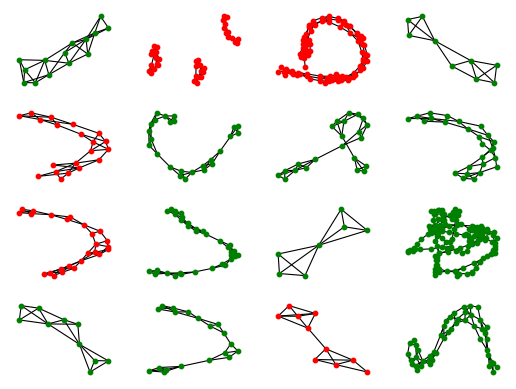

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import networkx as nx

fig, ax = plt.subplots(4, 4)

for i, data in enumerate(dataset[-16:]):
    # Calculate color (green if correct, red otherwise)
    out = gin(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis("off")
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(
        G,
        pos=nx.spring_layout(G, seed=0),
        with_labels=False,
        node_size=10,
        node_color=color,
        width=0.8,
        ax=ax[ix],
    )

In [34]:
gin.eval()
acc_gin = 0

for data in test_loader:
    # Get classifications
    out_gin = gin(data.x, data.edge_index, data.batch)
    # Calculate accuracy scores
    acc_gin += accuracy(out_gin.argmax(dim=1), data.y) / len(test_loader)

print(f"GIN accuracy: {acc_gin*100}%")

GIN accuracy: 70.57291567325592%
